# NeRF 數據流演示 📊

本筆記本詳細演示了 NeRF 從原始輸入數據到最終渲染的完整數據流程。

## 📋 內容概覽
1. 創建合成數據集
2. 數據加載和預處理
3. 射線生成過程
4. 3D 點採樣
5. 位置編碼
6. 批次數據準備
7. 數據流可視化

In [1]:
from matplotlib.font_manager import fontManager
print(fontManager.ttflist)

[FontEntry(fname='/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'), FontEntry(fname='/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable'

In [3]:
# 導入必要的庫
import sys
import os
sys.path.append('..')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from pathlib import Path

# 設置中文字體支援 - 使用 UTF-8 編碼
mpl.rc('font', family='Microsoft JhengHei')


# 導入我們的模組
from src.utils.data_utils import NeRFDataLoader, create_synthetic_dataset
from src.models.encoding import PositionalEncoder

# 設置隨機種子
torch.manual_seed(42)
np.random.seed(42)

print("🚀 NeRF 數據流演示開始！")

🚀 NeRF 數據流演示開始！


## 1. 創建合成數據集 🎨

首先，我們創建一個包含 100 張圖像的合成數據集來演示數據流程。

In [5]:
# 創建合成數據集
n_images = 100
image_size = (64, 64)  # (H, W)
output_dir = "../data/synthetic_demo"

print(f"📊 創建數據集參數:")
print(f"   - 圖像數量: {n_images}")
print(f"   - 圖像尺寸: {image_size}")
print(f"   - 輸出目錄: {output_dir}")

# 創建數據集
dataset = create_synthetic_dataset(
    n_images=n_images,
    image_size=image_size,
    output_dir=output_dir
)

print(f"\n✅ 數據集創建完成！")
print(f"   - 訓練集: 80 張圖像")
print(f"   - 驗證集: 10 張圖像")
print(f"   - 測試集: 10 張圖像")

📊 創建數據集參數:
   - 圖像數量: 100
   - 圖像尺寸: (64, 64)
   - 輸出目錄: ../data/synthetic_demo
🎨 創建合成數據集: 100 張圖像，尺寸 (64, 64)
✅ 合成數據集已保存到: ../data/synthetic_demo
   - 訓練集: 80 張圖像
   - 驗證集: 10 張圖像
   - 測試集: 10 張圖像

✅ 數據集創建完成！
   - 訓練集: 80 張圖像
   - 驗證集: 10 張圖像
   - 測試集: 10 張圖像


### 可視化原始數據

findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/2753042823.py:14: UserWarning: Glyph 35222 (\N{CJK UNIFIED IDEOGRAPH-8996}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/2753042823.py:14: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not f

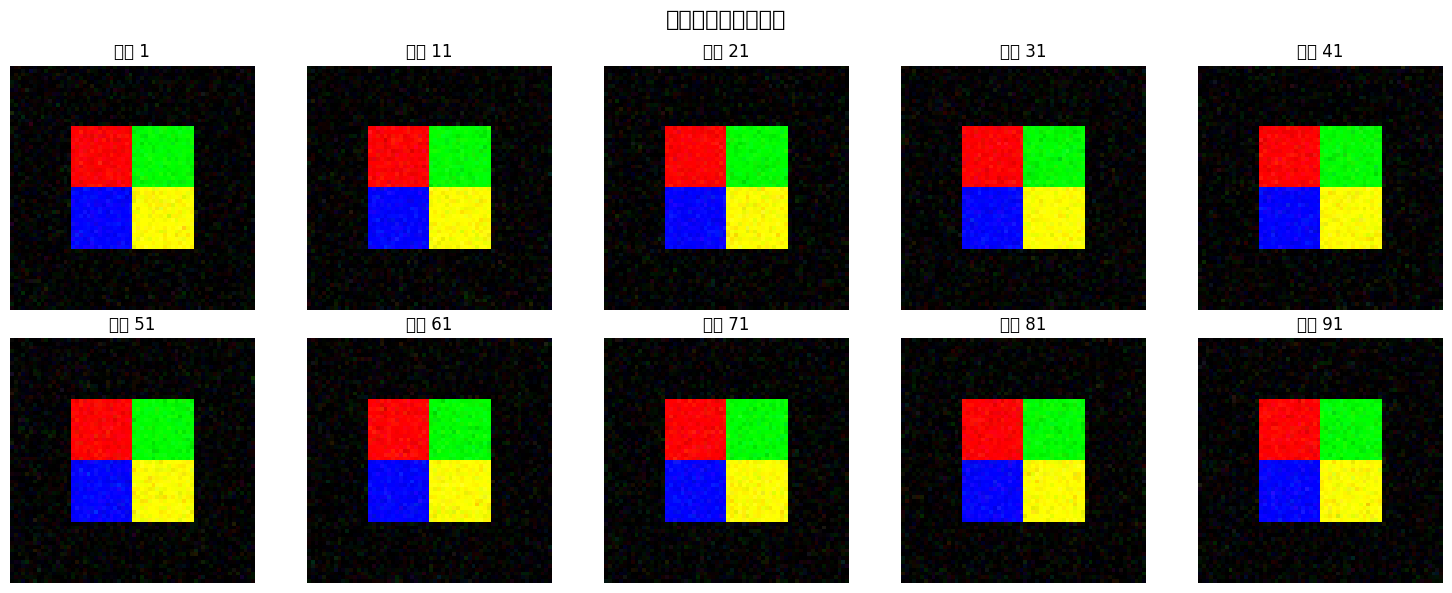

📸 圖像數據形狀: (100, 64, 64, 3)
📷 相機位姿形狀: (100, 4, 4)


In [6]:
# 可視化一些樣本圖像
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('合成數據集樣本圖像', fontsize=16)

for i in range(10):
    row = i // 5
    col = i % 5
    
    img = dataset['images'][i * 10]  # 每隔10張取一張
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'視角 {i * 10 + 1}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"📸 圖像數據形狀: {dataset['images'].shape}")
print(f"📷 相機位姿形狀: {dataset['poses'].shape}")

## 2. 數據加載和預處理 📂

使用我們的數據加載器來處理數據。

In [7]:
# 初始化數據加載器
data_loader = NeRFDataLoader(
    data_dir=output_dir,
    scene_name="synthetic_demo",
    image_scale=1.0,
    white_background=True
)

# 加載訓練數據
train_images = data_loader.load_images("train")
train_poses, train_intrinsics = data_loader.load_camera_parameters("train")

print(f"\n📊 訓練數據統計:")
print(f"   - 圖像形狀: {train_images.shape}")
print(f"   - 位姿形狀: {train_poses.shape}")
print(f"   - 內參形狀: {train_intrinsics.shape if train_intrinsics is not None else 'None'}")
print(f"   - 圖像尺寸: {data_loader.image_size}")

📂 初始化數據加載器: synthetic_demo
📸 加載 train 圖像...
✅ 加載了 80 張 train 圖像，尺寸: (64, 64)
📷 加載 train 相機參數...
✅ 加載了 80 個相機位姿

📊 訓練數據統計:
   - 圖像形狀: torch.Size([80, 64, 64, 3])
   - 位姿形狀: torch.Size([80, 4, 4])
   - 內參形狀: torch.Size([80, 3, 3])
   - 圖像尺寸: (64, 64)


### 分析相機軌跡

findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/2906901285.py:27: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/2906901285.py:27: UserWarning: Glyph 27231 (\N{CJK UNIFIED IDEOGRAPH-6A5F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/2906901285.py:27: UserWarning: Glyph 36556 (\N{CJK UNIFIED IDEOGRAPH-8ECC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/2906901285.py:27: UserWarning: Glyph 36321 (\N{CJK UNIFIED IDEOGRAPH-8DE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/2906901285.py:27: UserWarning: Glyph 22580 (\N{

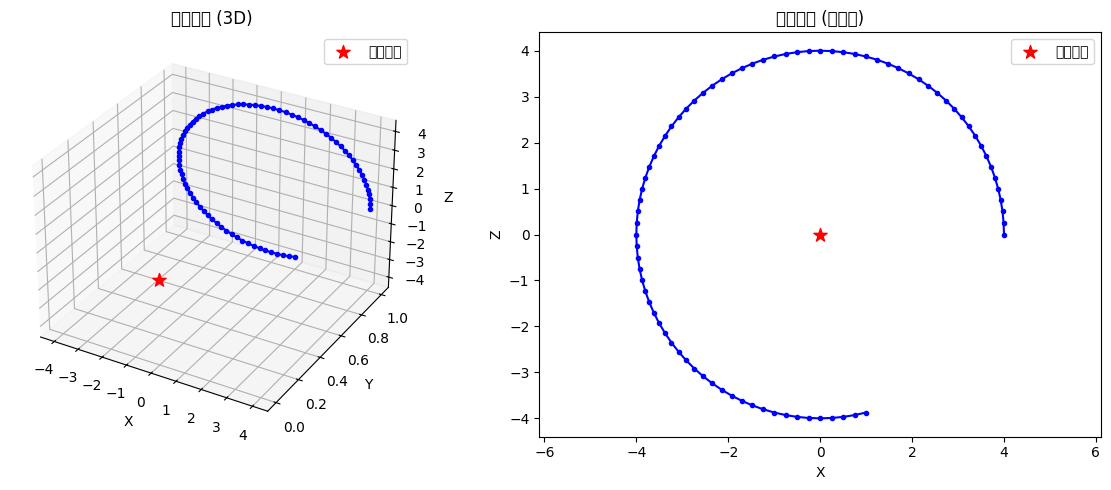

📍 相機位置統計:
   - X 範圍: [-4.00, 4.00]
   - Y 範圍: [1.00, 1.00]
   - Z 範圍: [-4.00, 4.00]


In [8]:
# 提取相機位置
camera_positions = train_poses[:, :3, 3].numpy()  # [N, 3]

# 3D 可視化相機軌跡
fig = plt.figure(figsize=(12, 5))

# 3D 軌跡圖
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2], 'b-o', markersize=3)
ax1.scatter([0], [0], [0], c='red', s=100, marker='*', label='場景中心')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('相機軌跡 (3D)')
ax1.legend()

# 俯視圖
ax2 = fig.add_subplot(122)
ax2.plot(camera_positions[:, 0], camera_positions[:, 2], 'b-o', markersize=3)
ax2.scatter([0], [0], c='red', s=100, marker='*', label='場景中心')
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('相機軌跡 (俯視圖)')
ax2.legend()
ax2.axis('equal')

plt.tight_layout()
plt.show()

print(f"📍 相機位置統計:")
print(f"   - X 範圍: [{camera_positions[:, 0].min():.2f}, {camera_positions[:, 0].max():.2f}]")
print(f"   - Y 範圍: [{camera_positions[:, 1].min():.2f}, {camera_positions[:, 1].max():.2f}]")
print(f"   - Z 範圍: [{camera_positions[:, 2].min():.2f}, {camera_positions[:, 2].max():.2f}]")

## 3. 射線生成過程 🔫

演示如何從像素座標生成 3D 射線。

In [9]:
# 為所有訓練圖像創建射線
print("🔫 生成射線...")
rays_o, rays_d = data_loader.create_rays(train_poses, train_intrinsics)

print(f"\n📊 射線數據統計:")
print(f"   - 射線起點形狀: {rays_o.shape}")
print(f"   - 射線方向形狀: {rays_d.shape}")
print(f"   - 每張圖像的射線數: {rays_o.shape[1] * rays_o.shape[2]}")
print(f"   - 總射線數: {rays_o.shape[0] * rays_o.shape[1] * rays_o.shape[2]}")

# 分析第一張圖像的射線
first_rays_o = rays_o[0]  # [H, W, 3]
first_rays_d = rays_d[0]  # [H, W, 3]

print(f"\n🔍 第一張圖像射線分析:")
print(f"   - 射線起點 (都相同): {first_rays_o[0, 0]}")
print(f"   - 中心射線方向: {first_rays_d[32, 32]}")
print(f"   - 左上角射線方向: {first_rays_d[0, 0]}")
print(f"   - 右下角射線方向: {first_rays_d[-1, -1]}")

🔫 生成射線...

📊 射線數據統計:
   - 射線起點形狀: torch.Size([80, 64, 64, 3])
   - 射線方向形狀: torch.Size([80, 64, 64, 3])
   - 每張圖像的射線數: 4096
   - 總射線數: 327680

🔍 第一張圖像射線分析:
   - 射線起點 (都相同): tensor([4., 1., 0.])
   - 中心射線方向: tensor([-0.9701, -0.2425,  0.0000])
   - 左上角射線方向: tensor([-1.0575,  0.1067,  0.3600])
   - 右下角射線方向: tensor([-0.8856, -0.5809, -0.3488])


### 可視化射線方向

findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/3371554625.py:22: UserWarning: Glyph 23556 (\N{CJK UNIFIED IDEOGRAPH-5C04}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/3371554625.py:22: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/3371554625.py:22: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

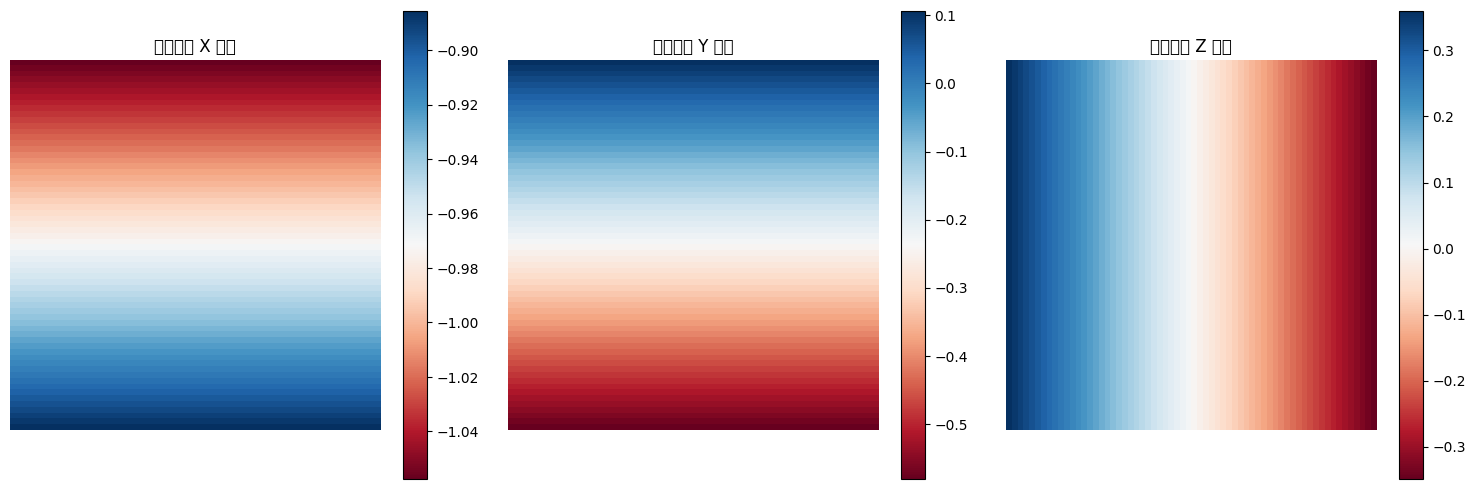

In [10]:
# 可視化射線方向的分佈
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# X 方向分量
im1 = axes[0].imshow(first_rays_d[:, :, 0].numpy(), cmap='RdBu')
axes[0].set_title('射線方向 X 分量')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# Y 方向分量
im2 = axes[1].imshow(first_rays_d[:, :, 1].numpy(), cmap='RdBu')
axes[1].set_title('射線方向 Y 分量')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

# Z 方向分量
im3 = axes[2].imshow(first_rays_d[:, :, 2].numpy(), cmap='RdBu')
axes[2].set_title('射線方向 Z 分量')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

## 4. 訓練數據採樣 🎯

演示如何從大量射線中採樣訓練批次。

In [11]:
# 獲取一個訓練批次
batch_size = 1024
batch_data = data_loader.get_training_data(batch_size=batch_size)

print(f"🎯 訓練批次數據:")
print(f"   - 批次大小: {batch_size}")
print(f"   - 射線起點: {batch_data['rays_o'].shape}")
print(f"   - 射線方向: {batch_data['rays_d'].shape}")
print(f"   - 目標顏色: {batch_data['target_rgb'].shape}")
print(f"   - 來源圖像索引: {batch_data['img_idx']}")

# 分析目標顏色分佈
target_rgb = batch_data['target_rgb']
print(f"\n🎨 目標顏色統計:")
print(f"   - R 通道範圍: [{target_rgb[:, 0].min():.3f}, {target_rgb[:, 0].max():.3f}]")
print(f"   - G 通道範圍: [{target_rgb[:, 1].min():.3f}, {target_rgb[:, 1].max():.3f}]")
print(f"   - B 通道範圍: [{target_rgb[:, 2].min():.3f}, {target_rgb[:, 2].max():.3f}]")

🎯 訓練批次數據:
   - 批次大小: 1024
   - 射線起點: torch.Size([1024, 3])
   - 射線方向: torch.Size([1024, 3])
   - 目標顏色: torch.Size([1024, 3])
   - 來源圖像索引: 22

🎨 目標顏色統計:
   - R 通道範圍: [0.000, 1.000]
   - G 通道範圍: [0.000, 1.000]
   - B 通道範圍: [0.000, 1.000]


### 可視化採樣的射線

findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/1602948538.py:31: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1602948538.py:31: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1602948538.py:31: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

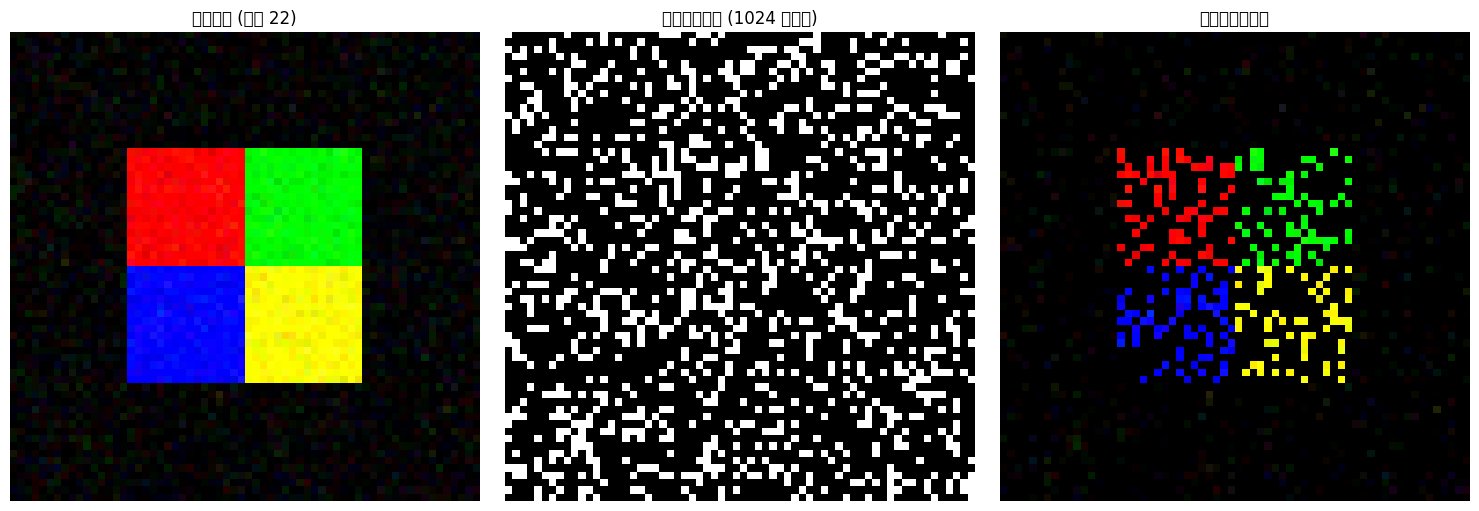

📊 採樣統計:
   - 採樣比例: 25.0%
   - 總像素數: 4096
   - 採樣像素數: 1024


In [12]:
# 可視化採樣的射線在圖像中的分佈
img_idx = batch_data['img_idx']
ray_indices = batch_data['ray_indices']
h, w = data_loader.image_size

# 創建採樣掩碼
sample_mask = torch.zeros(h * w, dtype=torch.bool)
sample_mask[ray_indices] = True
sample_mask = sample_mask.reshape(h, w)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 原始圖像
axes[0].imshow(train_images[img_idx])
axes[0].set_title(f'原始圖像 (索引 {img_idx})')
axes[0].axis('off')

# 採樣掩碼
axes[1].imshow(sample_mask.numpy(), cmap='gray')
axes[1].set_title(f'採樣射線分佈 ({batch_size} 條射線)')
axes[1].axis('off')

# 採樣的顏色
sampled_colors = torch.zeros(h, w, 3)
sampled_colors.view(-1, 3)[ray_indices] = target_rgb
axes[2].imshow(sampled_colors)
axes[2].set_title('採樣的像素顏色')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"📊 採樣統計:")
print(f"   - 採樣比例: {batch_size / (h * w) * 100:.1f}%")
print(f"   - 總像素數: {h * w}")
print(f"   - 採樣像素數: {batch_size}")

## 5. 3D 點採樣 📍

演示如何沿射線採樣 3D 點。

In [13]:
# 沿射線採樣 3D 點
near, far = 2.0, 6.0
n_samples = 64

# 獲取批次射線
batch_rays_o = batch_data['rays_o']  # [1024, 3]
batch_rays_d = batch_data['rays_d']  # [1024, 3]

print(f"📍 3D 點採樣參數:")
print(f"   - 近平面: {near}")
print(f"   - 遠平面: {far}")
print(f"   - 每條射線採樣點數: {n_samples}")

# 分層採樣
t_vals = torch.linspace(0., 1., steps=n_samples)
z_vals = near * (1. - t_vals) + far * t_vals  # 深度值
z_vals = z_vals.expand([batch_size, n_samples])  # [1024, 64]

# 添加隨機擾動 (分層採樣)
mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
upper = torch.cat([mids, z_vals[..., -1:]], -1)
lower = torch.cat([z_vals[..., :1], mids], -1)
t_rand = torch.rand(z_vals.shape)
z_vals_perturbed = lower + (upper - lower) * t_rand

# 計算 3D 點座標
pts = batch_rays_o[..., None, :] + batch_rays_d[..., None, :] * z_vals_perturbed[..., :, None]

print(f"\n📊 採樣結果:")
print(f"   - 深度值形狀: {z_vals_perturbed.shape}")
print(f"   - 3D 點形狀: {pts.shape}")
print(f"   - 總採樣點數: {pts.shape[0] * pts.shape[1]}")

print(f"\n🔍 深度值統計:")
print(f"   - 最小深度: {z_vals_perturbed.min():.3f}")
print(f"   - 最大深度: {z_vals_perturbed.max():.3f}")
print(f"   - 平均深度: {z_vals_perturbed.mean():.3f}")

📍 3D 點採樣參數:
   - 近平面: 2.0
   - 遠平面: 6.0
   - 每條射線採樣點數: 64

📊 採樣結果:
   - 深度值形狀: torch.Size([1024, 64])
   - 3D 點形狀: torch.Size([1024, 64, 3])
   - 總採樣點數: 65536

🔍 深度值統計:
   - 最小深度: 2.000
   - 最大深度: 6.000
   - 平均深度: 4.000


### 可視化 3D 點分佈

findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
findfont: Font family 'Microsoft JhengHei' not found.
/tmp/ipykernel_51690/1051107872.py:45: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1051107872.py:45: UserWarning: Glyph 25505 (\N{CJK UNIFIED IDEOGRAPH-63A1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1051107872.py:45: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1051107872.py:45: UserWarning: Glyph 21934 (\N{CJK UNIFIED IDEOGRAPH-55AE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/1051107872.py:45: UserWarning: Glyph 26781 (\N{CJK UNIFIED IDEOGRAPH-689D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51690/105

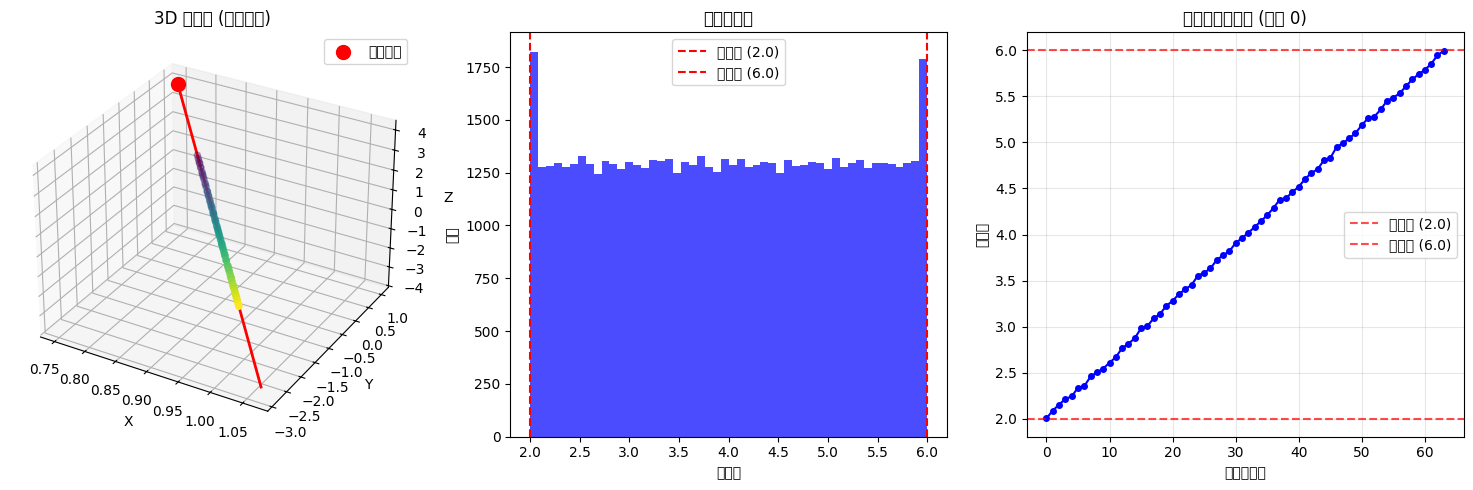

In [14]:
# 可視化一條射線上的採樣點
ray_idx = 0
sample_ray_o = batch_rays_o[ray_idx]  # [3]
sample_ray_d = batch_rays_d[ray_idx]  # [3]
sample_pts = pts[ray_idx]  # [64, 3]
sample_z_vals = z_vals_perturbed[ray_idx]  # [64]

fig = plt.figure(figsize=(15, 5))

# 3D 散點圖
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(sample_pts[:, 0], sample_pts[:, 1], sample_pts[:, 2], 
           c=sample_z_vals, cmap='viridis', s=20)
ax1.plot([sample_ray_o[0], sample_ray_o[0] + 8*sample_ray_d[0]], 
         [sample_ray_o[1], sample_ray_o[1] + 8*sample_ray_d[1]], 
         [sample_ray_o[2], sample_ray_o[2] + 8*sample_ray_d[2]], 'r-', linewidth=2)
ax1.scatter(*sample_ray_o, c='red', s=100, marker='o', label='射線起點')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D 點採樣 (單條射線)')
ax1.legend()

# 深度值分佈
ax2 = fig.add_subplot(132)
ax2.hist(z_vals_perturbed.flatten().numpy(), bins=50, alpha=0.7, color='blue')
ax2.axvline(near, color='red', linestyle='--', label=f'近平面 ({near})')
ax2.axvline(far, color='red', linestyle='--', label=f'遠平面 ({far})')
ax2.set_xlabel('深度值')
ax2.set_ylabel('頻率')
ax2.set_title('深度值分佈')
ax2.legend()

# 單條射線的深度值
ax3 = fig.add_subplot(133)
ax3.plot(range(n_samples), sample_z_vals.numpy(), 'bo-', markersize=4)
ax3.axhline(near, color='red', linestyle='--', alpha=0.7, label=f'近平面 ({near})')
ax3.axhline(far, color='red', linestyle='--', alpha=0.7, label=f'遠平面 ({far})')
ax3.set_xlabel('採樣點索引')
ax3.set_ylabel('深度值')
ax3.set_title(f'單條射線深度值 (射線 {ray_idx})')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 位置編碼 🔢

演示位置編碼如何將 3D 座標轉換為高維特徵。

In [ ]:
# 創建位置編碼器
pos_encoder = PositionalEncoder(
    input_dims=3,
    max_freq_log2=6,
    num_freqs=6,
    include_input=True
)

dir_encoder = PositionalEncoder(
    input_dims=3,
    max_freq_log2=4,
    num_freqs=4,
    include_input=True
)

print(f"🔢 位置編碼器參數:")
print(f"   - 位置編碼維度: {pos_encoder.out_dim}")
print(f"   - 方向編碼維度: {dir_encoder.out_dim}")
print(f"   - 位置頻率數: {pos_encoder.num_freqs}")
print(f"   - 方向頻率數: {dir_encoder.num_freqs}")

# 準備數據進行編碼
pts_flat = pts.reshape(-1, 3)  # [65536, 3]

# 準備觀看方向
viewdirs = batch_rays_d / torch.norm(batch_rays_d, dim=-1, keepdim=True)
viewdirs = viewdirs[:, None].expand(pts.shape)  # [1024, 64, 3]
dirs_flat = viewdirs.reshape(-1, 3)  # [65536, 3]

print(f"\n📊 編碼前數據:")
print(f"   - 3D 點形狀: {pts_flat.shape}")
print(f"   - 觀看方向形狀: {dirs_flat.shape}")

# 進行位置編碼
pts_encoded = pos_encoder.encode(pts_flat)
dirs_encoded = dir_encoder.encode(dirs_flat)

print(f"\n📊 編碼後數據:")
print(f"   - 編碼位置形狀: {pts_encoded.shape}")
print(f"   - 編碼方向形狀: {dirs_encoded.shape}")
print(f"   - 總特徵維度: {pts_encoded.shape[1] + dirs_encoded.shape[1]}")

### 可視化位置編碼效果

In [ ]:
# 可視化位置編碼的效果
sample_pts = pts_flat[:1000]  # 取前1000個點
sample_encoded = pos_encoder.encode(sample_pts)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 原始座標
for i, coord_name in enumerate(['X', 'Y', 'Z']):
    axes[0, i].scatter(range(1000), sample_pts[:, i].numpy(), alpha=0.6, s=1)
    axes[0, i].set_title(f'原始 {coord_name} 座標')
    axes[0, i].set_xlabel('點索引')
    axes[0, i].set_ylabel(f'{coord_name} 值')

# 編碼後的特徵 (顯示前幾個維度)
feature_indices = [3, 10, 20]  # 選擇一些編碼維度
for i, feat_idx in enumerate(feature_indices):
    axes[1, i].scatter(range(1000), sample_encoded[:, feat_idx].numpy(), alpha=0.6, s=1)
    axes[1, i].set_title(f'編碼特徵維度 {feat_idx}')
    axes[1, i].set_xlabel('點索引')
    axes[1, i].set_ylabel('特徵值')

plt.tight_layout()
plt.show()

# 分析編碼特徵的統計信息
print(f"🔍 編碼特徵統計:")
print(f"   - 特徵值範圍: [{sample_encoded.min():.3f}, {sample_encoded.max():.3f}]")
print(f"   - 特徵均值: {sample_encoded.mean():.3f}")
print(f"   - 特徵標準差: {sample_encoded.std():.3f}")

## 7. 完整數據流程總結 📋

總結整個數據流程中的關鍵數據變換。

In [ ]:
# 創建數據流程總結
data_flow_summary = {
    "階段1_原始數據": {
        "圖像數量": n_images,
        "圖像尺寸": f"{image_size[0]}×{image_size[1]}",
        "訓練圖像": train_images.shape,
        "相機位姿": train_poses.shape
    },
    "階段2_射線生成": {
        "射線起點": rays_o.shape,
        "射線方向": rays_d.shape,
        "每圖像射線數": rays_o.shape[1] * rays_o.shape[2],
        "總射線數": rays_o.shape[0] * rays_o.shape[1] * rays_o.shape[2]
    },
    "階段3_批次採樣": {
        "批次大小": batch_size,
        "批次射線起點": batch_data['rays_o'].shape,
        "批次射線方向": batch_data['rays_d'].shape,
        "目標顏色": batch_data['target_rgb'].shape
    },
    "階段4_3D點採樣": {
        "每射線採樣點數": n_samples,
        "3D點座標": pts.shape,
        "深度值": z_vals_perturbed.shape,
        "總採樣點數": pts.shape[0] * pts.shape[1]
    },
    "階段5_位置編碼": {
        "原始3D點": pts_flat.shape,
        "編碼位置": pts_encoded.shape,
        "編碼方向": dirs_encoded.shape,
        "總特徵維度": pts_encoded.shape[1] + dirs_encoded.shape[1]
    }
}

print("📋 NeRF 數據流程總結")
print("=" * 50)

for stage, info in data_flow_summary.items():
    print(f"\n{stage.replace('_', ' ')}:")
    for key, value in info.items():
        print(f"   {key}: {value}")

# 計算記憶體使用估算
print("\n💾 記憶體使用估算:")
print("=" * 30)

# 假設 float32 (4 bytes)
bytes_per_float = 4

image_memory = np.prod(train_images.shape) * bytes_per_float / 1024**2
rays_memory = np.prod(rays_o.shape) * 2 * bytes_per_float / 1024**2  # 起點+方向
batch_memory = (np.prod(pts_encoded.shape) + np.prod(dirs_encoded.shape)) * bytes_per_float / 1024**2

print(f"   訓練圖像: {image_memory:.1f} MB")
print(f"   所有射線: {rays_memory:.1f} MB")
print(f"   批次編碼特徵: {batch_memory:.1f} MB")
print(f"   總計: {image_memory + rays_memory + batch_memory:.1f} MB")

## 8. 數據流可視化 📊

創建一個完整的數據流程圖。

In [ ]:
# 創建數據流程可視化
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# 定義流程步驟
steps = [
    {"name": "原始圖像\n100張 64×64×3", "pos": (1, 9), "color": "lightblue"},
    {"name": "相機參數\n100個 4×4 位姿", "pos": (3, 9), "color": "lightgreen"},
    {"name": "數據分割\n80/10/10", "pos": (2, 7.5), "color": "lightyellow"},
    {"name": "射線生成\n80×64×64×3", "pos": (2, 6), "color": "lightcoral"},
    {"name": "隨機採樣\n1024 條射線", "pos": (2, 4.5), "color": "lightpink"},
    {"name": "3D點採樣\n1024×64×3", "pos": (2, 3), "color": "lightsteelblue"},
    {"name": "位置編碼\n65536×39", "pos": (1, 1.5), "color": "lightsalmon"},
    {"name": "方向編碼\n65536×27", "pos": (3, 1.5), "color": "lightsalmon"},
    {"name": "NeRF網絡\nRGB + 密度", "pos": (2, 0), "color": "lightgray"}
]

# 繪製步驟框
for step in steps:
    rect = patches.FancyBboxPatch(
        (step["pos"][0]-0.4, step["pos"][1]-0.3), 0.8, 0.6,
        boxstyle="round,pad=0.1", 
        facecolor=step["color"], 
        edgecolor="black",
        linewidth=1
    )
    ax.add_patch(rect)
    ax.text(step["pos"][0], step["pos"][1], step["name"], 
           ha="center", va="center", fontsize=10, weight="bold")

# 繪製箭頭
arrows = [
    ((2, 8.7), (2, 8.1)),      # 數據分割
    ((2, 7.2), (2, 6.6)),      # 射線生成
    ((2, 5.7), (2, 5.1)),      # 隨機採樣
    ((2, 4.2), (2, 3.6)),      # 3D點採樣
    ((1.6, 2.7), (1.2, 2.1)),  # 位置編碼
    ((2.4, 2.7), (2.8, 2.1)),  # 方向編碼
    ((1.5, 1.2), (1.8, 0.6)),  # 到NeRF網絡
    ((2.5, 1.2), (2.2, 0.6))   # 到NeRF網絡
]

for start, end in arrows:
    ax.annotate("", xy=end, xytext=start,
               arrowprops=dict(arrowstyle="->", lw=2, color="darkblue"))

# 添加數據量標註
data_annotations = [
    ((4.5, 9), "100 張圖像\n每張 4096 像素"),
    ((4.5, 6), "327,680,000 條射線\n(80×64×64×1000)"),
    ((4.5, 4.5), "每批次 1024 條\n隨機採樣"),
    ((4.5, 3), "65,536 個 3D 點\n(1024×64)"),
    ((4.5, 1.5), "高維特徵向量\n39+27=66 維"),
    ((4.5, 0), "RGB 顏色 + 密度\n每點 4 個值")
]

for pos, text in data_annotations:
    ax.text(pos[0], pos[1], text, ha="left", va="center", 
           fontsize=9, style="italic", color="darkgreen")

ax.set_xlim(0, 6)
ax.set_ylim(-0.5, 10)
ax.set_title("NeRF 數據流程圖", fontsize=16, weight="bold", pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

## 🎯 總結

通過這個演示，我們詳細了解了 NeRF 的完整數據流程：

### 關鍵數據變換
1. **圖像 → 射線**: 每個像素生成一條 3D 射線
2. **射線 → 3D點**: 沿射線採樣多個 3D 點
3. **3D點 → 高維特徵**: 位置編碼擴展特徵維度
4. **特徵 → 預測**: NeRF 網絡預測顏色和密度
5. **預測 → 像素**: 體積渲染合成最終像素顏色

### 數據規模
- **輸入**: 100 張 64×64 圖像
- **射線**: 每張圖像 4,096 條射線
- **採樣**: 每條射線 64 個 3D 點
- **特徵**: 每個點 66 維編碼特徵
- **批次**: 每次處理 1,024 條射線

### 設計優勢
- **並行化**: 所有計算都可以批次處理
- **隨機性**: 隨機採樣提高訓練效率
- **可擴展**: 支持不同解析度和場景規模
- **模組化**: 每個步驟都可以獨立優化

這個數據流程設計使得 NeRF 能夠高效地從 2D 圖像學習 3D 場景表示！